In [ ]:


import numpy as np
from sklearn.decomposition import KernelPCA

In [2]:
from soap import *

In [3]:
_, structure, species = read_cif("CIF_files/DB0-m1_o14_smb_repeat.cif")

In [4]:
soap_out, soap = S(structure = structure, species = species)

In [6]:
soap_out.shape

(213, 20)

In [7]:
N_env, N_feat = soap_out.shape

In [11]:
# 1) Build the N_env × N_env kernel among environments.  
#    For example, use an RBF kernel with some gamma > 0.
def rbf_kernel(u, v, gamma=1e-3):
    diff = u - v
    return np.exp(-gamma * (diff @ diff))

K = np.zeros((N_env, N_env))
for i in range(N_env):
    for j in range(N_env):
        K[i, j] = rbf_kernel(soap_out[i], soap_out[j], gamma=1e-3)

eigvals, eigvecs = np.linalg.eigh(K)
alpha = eigvecs[:, -1]       # shape = (N_env,)
# (Optionally, you can normalize alpha so that sum(alpha^2)=1 or so that sum(alpha)=1, etc.)
alpha = alpha / np.linalg.norm(alpha)

# --- 3) Form the weighted‐sum row d = alpha^T @ soap_out ---
d = alpha.reshape(1, N_env) @ soap_out   # shape = (1, N_feat)

print("collapsed descriptor shape:", d.shape)

collapsed descriptor shape: (1, 20)


In [17]:
d[0]

array([-4.29396800e+01, -7.76591118e-01, -6.10796517e+01,  7.41633485e-01,
       -2.48782458e+00,  4.41300806e-02, -1.50099893e-01,  2.19073161e-02,
       -2.05581195e+02, -4.83435708e+00, -2.37979335e+01,  2.37159273e-01,
       -1.81910368e+00,  2.03033009e-01, -2.98549818e+01, -3.40070064e-01,
       -7.09092416e+00, -4.51915788e-02, -6.53136502e+00, -1.20871675e-01])

In [21]:
si = S(structure = structure, species = species, average = "inner")

In [22]:
si

array([ 1.52091564e+00,  4.50189564e-05,  4.16378818e+00, -2.95287154e-05,
        1.03914068e+00,  2.32330997e-06,  2.98309005e-01, -1.78135509e-05,
        1.13991411e+01,  4.20726344e-05,  2.84484003e+00, -2.26701741e-05,
        8.16676138e-01,  1.01262552e-05,  7.09975838e-01,  2.98115188e-05,
        2.03814738e-01, -9.46465465e-06,  5.85096637e-02,  1.71519504e-05])

In [23]:
so = S(structure = structure, species = species, average = "outer")

In [24]:
so

array([ 2.77902631e+00,  5.32198372e-02,  4.11588378e+00, -5.19847926e-02,
        1.63876232e-01, -2.68026443e-03,  9.99165625e-03, -1.45617068e-03,
        1.54767122e+01,  3.17557746e-01,  1.59166562e+00, -1.56041520e-02,
        1.21731496e-01, -1.35054514e-02,  1.99147215e+00,  2.26188261e-02,
        4.92624250e-01,  2.93805103e-03,  4.62426975e-01,  8.11873260e-03])

In [20]:
import numpy as np
import matplotlib.pyplot as plt

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

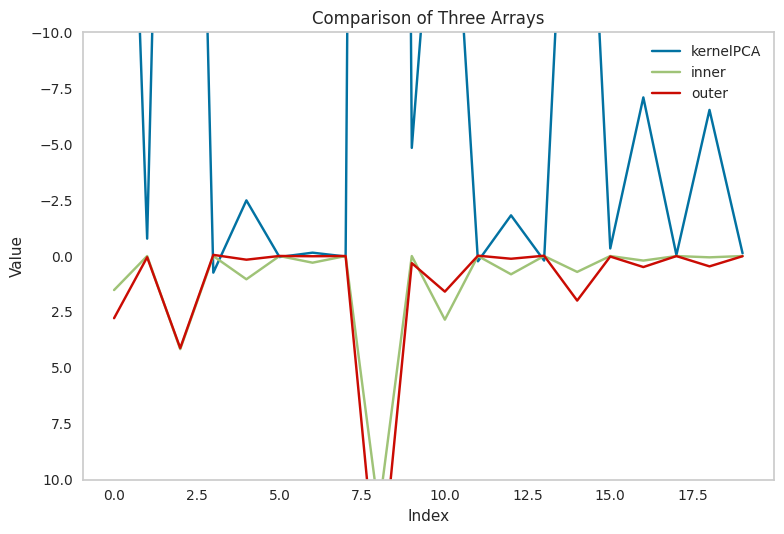

In [60]:
plt.plot(np.arange(20), d[0], label='kernelPCA')
plt.plot(np.arange(20), si, label='inner')
plt.plot(np.arange(20), so, label='outer')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Three Arrays')
plt.legend()
plt.ylim(10,-10)
plt.grid()
plt.tight_layout()
plt.show()

# ML

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.neural_network import MLPRegressor


In [2]:
# Read feature descriptors
X = pd.read_csv('kernelPCA_soap_mofs.csv')

# Read labels
y = pd.read_csv('id_labels.csv')


In [3]:
print(X.shape)
print(y.shape)

(3089, 485)
(3089, 2)


In [4]:
X['filename'] = X['filename'].str.replace('.cif', ' ', regex=False)

In [5]:
X.head()

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
0,9.913646,0.219398,12.334559,-0.045885,0.336669,0.000244,0.010825,-0.00259,56.320046,1.095121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-14.362669,-0.208199,-17.941820,0.151508,-0.773448,0.027419,0.000000,0.00000,-87.928944,-1.807842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-27.892495,-0.389759,-32.693050,0.408320,-0.277294,0.002432,0.000000,0.00000,-103.180044,-2.936626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.117354,0.191295,1.691878,-0.006119,0.058703,-0.005025,0.000000,0.00000,28.218185,0.359567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.387776,0.387618,0.756924,-0.022541,0.294804,-0.014325,0.000000,0.00000,2.496534,0.118561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
for i in range(len(X.columns)):
    print(i, X.columns[i])

0 C-C_1
1 C-C_2
2 C-H_1
3 C-H_2
4 C-O_1
5 C-O_2
6 C-V_1
7 C-V_2
8 H-H_1
9 H-H_2
10 H-O_1
11 H-O_2
12 H-V_1
13 H-V_2
14 O-O_1
15 O-O_2
16 O-V_1
17 O-V_2
18 V-V_1
19 V-V_2
20 filename
21 C-Zn_1
22 C-Zn_2
23 H-Zn_1
24 H-Zn_2
25 O-Zn_1
26 O-Zn_2
27 Zn-Zn_1
28 Zn-Zn_2
29 C-N_1
30 C-N_2
31 H-N_1
32 H-N_2
33 N-N_1
34 N-N_2
35 N-O_1
36 N-O_2
37 N-Zn_1
38 N-Zn_2
39 C-Er_1
40 C-Er_2
41 Er-Er_1
42 Er-Er_2
43 Er-H_1
44 Er-H_2
45 Er-O_1
46 Er-O_2
47 C-F_1
48 C-F_2
49 F-F_1
50 F-F_2
51 F-H_1
52 F-H_2
53 F-N_1
54 F-N_2
55 F-O_1
56 F-O_2
57 F-Zn_1
58 F-Zn_2
59 C-Cu_1
60 C-Cu_2
61 C-Li_1
62 C-Li_2
63 Cu-Cu_1
64 Cu-Cu_2
65 Cu-H_1
66 Cu-H_2
67 Cu-Li_1
68 Cu-Li_2
69 Cu-O_1
70 Cu-O_2
71 H-Li_1
72 H-Li_2
73 Li-Li_1
74 Li-Li_2
75 Li-O_1
76 Li-O_2
77 C-Fe_1
78 C-Fe_2
79 Fe-Fe_1
80 Fe-Fe_2
81 Fe-H_1
82 Fe-H_2
83 Fe-N_1
84 Fe-N_2
85 Fe-O_1
86 Fe-O_2
87 C-S_1
88 C-S_2
89 H-S_1
90 H-S_2
91 Li-S_1
92 Li-S_2
93 Li-Zn_1
94 Li-Zn_2
95 O-S_1
96 O-S_2
97 S-S_1
98 S-S_2
99 S-Zn_1
100 S-Zn_2
101 Cu-N_1
102 Cu-N_2
103 Cu-

In [7]:
y.head()

,id,label
0,DB5-hypotheticalMOF_17652_0_0_1_21_9_7_repeat,13.791591
1,DB0-m2_o8_o23_f0_pcu.sym.80_repeat,3.786996
2,DB0-m29_o90_o1500_f0_pts.sym.31_repeat,9.382537
3,DB0-m3_o48_o25_f0_fsc.sym.3_repeat,11.650365
4,DB0-m2_o1_o9_f0_nbo.sym.104_repeat,1.412915


In [8]:
X.set_index('filename', inplace = True)

In [9]:
y.set_index('id', inplace = True)

In [10]:
X.sort_index(inplace=True)

In [11]:
y.sort_index(inplace=True)

In [12]:
print("Are they exactly equal?", (X.index == y.index).all())

Are they exactly equal? True


In [13]:
X

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,40.658326,0.872530,4.724603e+01,-2.168800e-01,0.000000e+00,0.000000e+00,0.0,0.0,115.126355,2.783759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,47.207624,0.949492,6.683110e+01,-8.605906e-01,0.000000e+00,0.000000e+00,0.0,0.0,191.957852,4.651014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,25.064538,0.550652,9.088210e-03,-2.623691e-04,5.234567e-02,-2.544308e-03,0.0,0.0,1.406009,0.000301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,-23.961028,-0.480480,-3.108785e-04,7.704846e-05,-5.225086e-02,1.253006e-03,0.0,0.0,-1.679638,-0.008051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,-20.795926,-0.425793,-1.041316e-07,4.873777e-08,-8.102657e-08,3.166820e-08,0.0,0.0,-1.543582,-0.011597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,-55.720132,-1.126934,-8.630464e-01,2.850719e-02,-3.582946e-02,4.497977e-03,0.0,0.0,-19.618074,-0.234278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,-36.428858,-0.654314,-7.325740e-02,-2.999719e-04,-2.361746e-02,4.351298e-03,0.0,0.0,-7.732321,-0.176023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,-239.123642,-3.567468,-1.271953e+01,1.062072e-01,-1.648585e+00,2.037710e-02,0.0,0.0,-21.302741,-0.259695,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.225474,0.001811,0.0,0.0


In [14]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
X

,C-C_1,C-C_2,C-H_1,C-H_2,C-O_1,C-O_2,C-V_1,C-V_2,H-H_1,H-H_2,...,Dy-N_1,Dy-N_2,Dy-O_1,Dy-O_2,Al-F_1,Al-F_2,Br-Co_1,Br-Co_2,F-Ti_1,F-Ti_2
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m12_o14_bcu_repeat,40.658326,0.872530,4.724603e+01,-2.168800e-01,0.000000e+00,0.000000e+00,0.0,0.0,115.126355,2.783759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m12_o8_o32_tfz-d_repeat,47.207624,0.949492,6.683110e+01,-8.605906e-01,0.000000e+00,0.000000e+00,0.0,0.0,191.957852,4.651014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o11_o140_f0_fsc_repeat,25.064538,0.550652,9.088210e-03,-2.623691e-04,5.234567e-02,-2.544308e-03,0.0,0.0,1.406009,0.000301,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o14_o137_f0_fsc_repeat,-23.961028,-0.480480,-3.108785e-04,7.704846e-05,-5.225086e-02,1.253006e-03,0.0,0.0,-1.679638,-0.008051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB0-m15_o15_o48_f0_fsc_repeat,-20.795926,-0.425793,-1.041316e-07,4.873777e-08,-8.102657e-08,3.166820e-08,0.0,0.0,-1.543582,-0.011597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DB7-ddmof_5561_repeat,-55.720132,-1.126934,-8.630464e-01,2.850719e-02,-3.582946e-02,4.497977e-03,0.0,0.0,-19.618074,-0.234278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5786_repeat,-36.428858,-0.654314,-7.325740e-02,-2.999719e-04,-2.361746e-02,4.351298e-03,0.0,0.0,-7.732321,-0.176023,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
DB7-ddmof_5952_repeat,-239.123642,-3.567468,-1.271953e+01,1.062072e-01,-1.648585e+00,2.037710e-02,0.0,0.0,-21.302741,-0.259695,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.225474,0.001811,0.0,0.0


In [17]:
# Step 1: Scale X
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 3: Train linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Predict
y_pred = model.predict(X_test)

# Step 5: Evaluate
print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 275135888162539.62
R² Score: -1.286254765026707e+27


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_pred_train_rf = rf.predict(X_train)




/home/mmm9886/.conda/envs/pyemma/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [19]:
# Evaluate
print("Random Forest test RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("Random Forest test R²:", r2_score(y_test, y_pred_rf))

print("Random Forest train RMSE:", root_mean_squared_error(y_train, y_pred_train_rf))
print("Random Forest train R²:", r2_score(y_train, y_pred_train_rf))

Random Forest test RMSE: 3.925729216888397
Random Forest test R²: 0.7381375710888829
Random Forest train RMSE: 1.428242916678489
Random Forest train R²: 0.9671188032971597


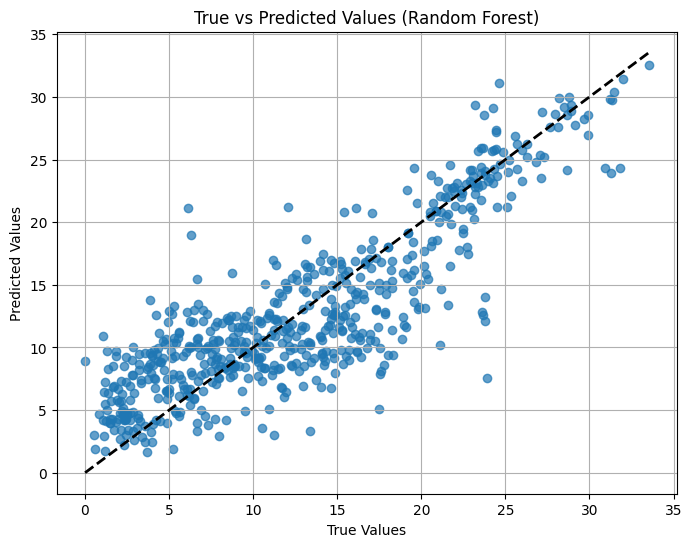

In [20]:
# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)

# Plot a diagonal reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Labels
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

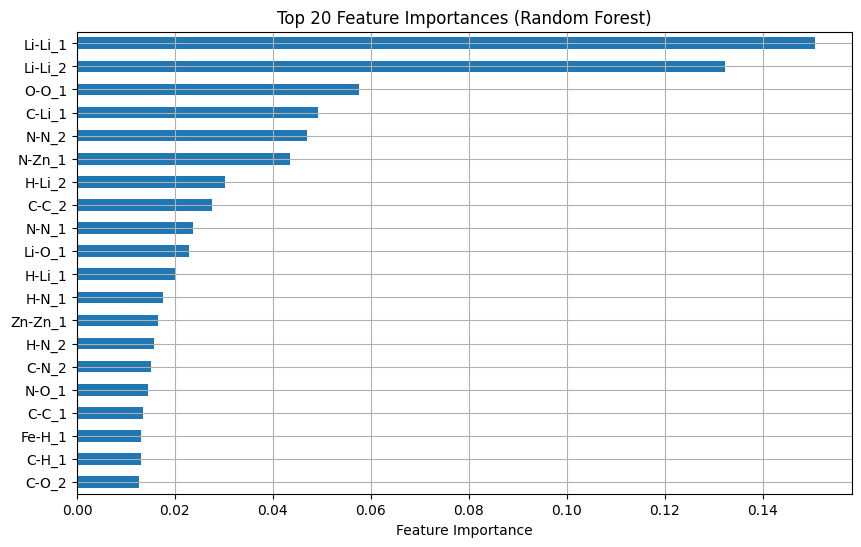

In [21]:
# 1. Get feature importances
importances = rf.feature_importances_

# 2. Map them to feature names
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names)

# 3. Sort them descending
feature_importances = feature_importances.sort_values(ascending=False)

# 4. Plot the top N features
top_n = 20  # you can change to top 10, 20, etc.

plt.figure(figsize=(10, 6))
feature_importances[:top_n].plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.grid(True)
plt.show()

In [22]:
import shap

In [23]:
explainer = shap.TreeExplainer(rf)


In [24]:
shap_values = explainer(X_test)

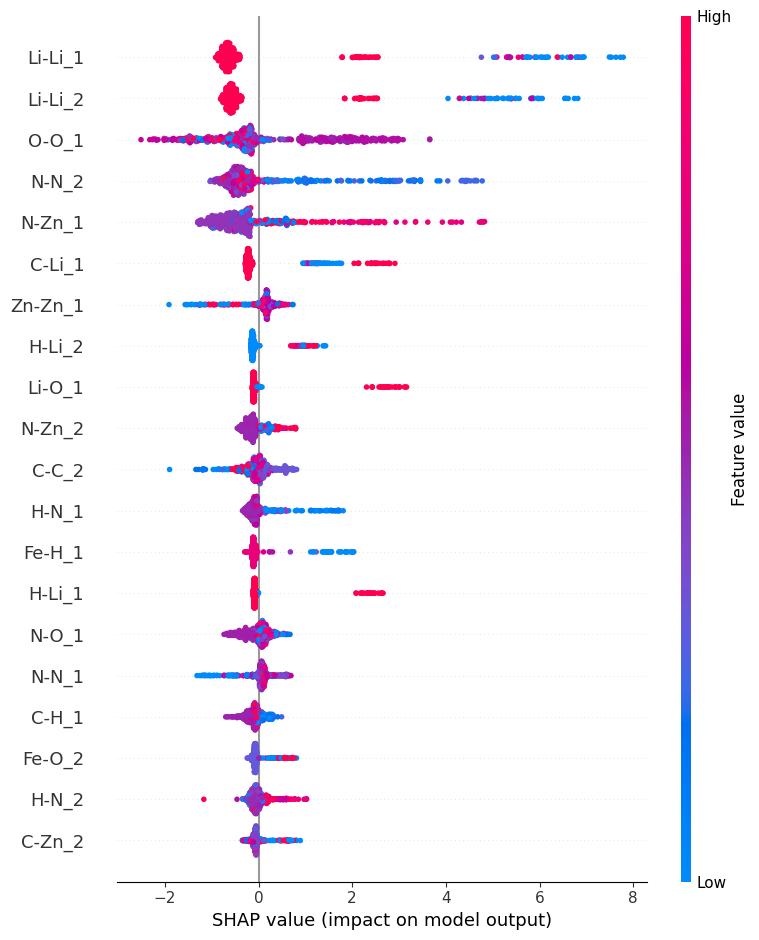

In [25]:
shap.summary_plot(shap_values, X_test)

In [22]:
from pycaret.regression import *

In [23]:
y

,label
id,
DB0-m12_o14_bcu_repeat,16.427428
DB0-m12_o8_o32_tfz-d_repeat,7.214721
DB0-m15_o11_o140_f0_fsc_repeat,16.199601
DB0-m15_o14_o137_f0_fsc_repeat,8.401891
DB0-m15_o15_o48_f0_fsc_repeat,5.446165
...,...
DB7-ddmof_5561_repeat,4.954847
DB7-ddmof_5786_repeat,5.020765
DB7-ddmof_5952_repeat,6.185781


In [24]:
data = pd.concat([X, y], axis = 1)

In [ ]:
data

In [ ]:
exp1 = setup(data, target='label', session_id=123)

In [ ]:
best_model = compare_models()

In [28]:
tuned_model_et = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.1215,24.4707,4.9468,0.6446,0.5344,1.5606
1,3.9469,23.9435,4.8932,0.6158,0.4947,0.6344
2,3.9610,24.3766,4.9373,0.6406,0.5343,0.7496
3,4.2786,25.9836,5.0974,0.5473,0.5683,0.8722
4,3.8479,21.7792,4.6668,0.5718,0.5440,0.7925
5,4.0509,24.0678,4.9059,0.5672,0.5303,0.7228
6,4.1232,23.8568,4.8843,0.5882,0.5010,0.6561
7,4.3785,26.3500,5.1332,0.5878,0.5487,0.7773
8,4.2377,25.0606,5.0061,0.6175,0.5443,0.7811


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [29]:
tuned_model_rf = tune_model(create_model('rf'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0119,15.5164,3.9391,0.7747,0.4286,1.0348
1,3.0080,16.5659,4.0701,0.7342,0.3885,0.4045
2,2.9682,14.6227,3.8240,0.7844,0.4212,0.5063
3,3.1304,15.5835,3.9476,0.7285,0.4472,0.5904
4,2.9086,14.8737,3.8566,0.7076,0.4509,0.5612
5,2.9136,13.4640,3.6693,0.7579,0.4195,0.4990
6,3.6216,21.0609,4.5892,0.6364,0.4475,0.5050
7,3.2831,17.6454,4.2006,0.7239,0.4469,0.5396
8,2.9458,15.0509,3.8796,0.7703,0.4076,0.4696


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3540,17.2212,4.1498,0.7499,0.4604,1.2186
1,3.3102,18.4923,4.3003,0.7033,0.4250,0.4859
2,3.2572,16.5891,4.0730,0.7554,0.4529,0.5828
3,3.5233,17.8997,4.2308,0.6882,0.4787,0.6716
4,3.2638,16.4872,4.0604,0.6759,0.4784,0.6341
5,3.2812,16.2586,4.0322,0.7077,0.4511,0.5591
6,3.8954,22.3219,4.7246,0.6147,0.4658,0.5659
7,3.6430,20.1952,4.4939,0.6841,0.4676,0.5929
8,3.3888,17.6612,4.2025,0.7305,0.4493,0.5706


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
tuned_model_xg = tune_model(create_model('xgboost'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4617,19.2560,4.3882,0.7204,0.4697,1.1653
1,3.2201,18.9816,4.3568,0.6954,0.4204,0.4095
2,2.9371,14.9482,3.8663,0.7796,0.4304,0.4715
3,3.3167,19.6765,4.4358,0.6572,0.4760,0.6102
4,3.1659,17.8344,4.2231,0.6494,0.4668,0.5705
5,2.9913,14.1051,3.7557,0.7464,0.4444,0.4810
6,3.6170,21.9147,4.6813,0.6217,0.4640,0.5094
7,3.3604,19.3320,4.3968,0.6976,0.4884,0.5502
8,3.1644,17.7970,4.2186,0.7284,0.4313,0.4630


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0592,15.6409,3.9549,0.7729,0.4166,1.1081
1,3.0793,17.5297,4.1869,0.7187,0.4191,0.4036
2,3.0510,15.5787,3.9470,0.7703,0.4194,0.4833
3,3.2074,17.2547,4.1539,0.6994,0.4676,0.6139
4,3.0493,15.8055,3.9756,0.6893,0.4598,0.5457
5,3.0003,13.9238,3.7315,0.7496,0.4142,0.4751
6,3.4982,20.9135,4.5731,0.6390,0.4575,0.5029
7,3.2908,18.7659,4.3320,0.7064,0.4639,0.5313
8,2.9329,14.5606,3.8158,0.7778,0.4048,0.4724


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
tuned_model_lgbm = tune_model(create_model('lightgbm'))

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:23:09
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/4 [00:00<?, ?it/s]